In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress, chi2_contingency
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [2]:
df= pd.read_csv('./hmeq.csv')
df.BAD.mask(df.BAD == 0,"Cleared")
df.BAD.mask(df.BAD == 1,"Defaulted")
df.BAD = le.fit_transform(df.BAD)
# def hotEncode(df:pd.DataFrame,column:str):
#     new_columns=list(filter(lambda val: not pd.isnull(val),df[column].unique()))
#     for append in new_columns:
#         df[append]=df[column]==append
#         df[append]=df[append].astype(int)
#     df.drop(column,axis=1)
#     return df

# df = hotEncode(df,"REASON")
# df = hotEncode(df,"JOB")
# df = df.drop(["JOB","REASON"],axis=1)



In [3]:
print("columns",list(df.columns.values))
data=df[df.columns.values]
sns.pairplot(df,kind="scatter")
plt.show()

columns ['BAD', 'LOAN', 'MORTDUE', 'VALUE', 'REASON', 'JOB', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']


In [ ]:
corr=df.corr()
corr = corr.iloc[0]
corr
pd.crosstab(df.REASON,df.BAD)
print(chi2_contingency(pd.crosstab(df.REASON,df.BAD))) ## really low p value; no linear relationship
print(chi2_contingency(pd.crosstab(df.JOB,df.BAD)))

(8.039751291499368, 0.004576181950707231, 1, array([[3142.81289418,  785.18710582],
       [1424.18710582,  355.81289418]]))
(81.93248953692773, 3.306676232858524e-16, 5, array([[ 609.57665904,  157.42334096],
       [ 753.42721352,  194.57278648],
       [1897.8736138 ,  490.1263862 ],
       [1014.10667136,  261.89332864],
       [  86.62823447,   22.37176553],
       [ 153.38760782,   39.61239218]]))


In [ ]:
test = df.dropna()
pear = corr[np.abs(corr) > 0] ## All columns with a moderate Pearson Correlation Coefficient
# pear = pear.drop("BAD")
pear_columns = []
for dataset in pear.iteritems():
    # print(test["BAD"])
    # print(test[dataset[0]])
    print("testing BAD vs ",dataset[0])
    res = (linregress(test["BAD"],test[dataset[0]])) ## All pvalues are great than 0.05
    print(res)
    if(res.pvalue > 0.05):
        pear_columns.append(dataset[0])
# print(np.corrcoef(test["LOAN"].dropna(),test["MORTDUE"]))
# print(linregress(test["LOAN"],test["MORTDUE"]))

testing BAD vs  BAD
LinregressResult(slope=1.0, intercept=0.0, rvalue=1.0, pvalue=0.0, stderr=0.0, intercept_stderr=0.0)
testing BAD vs  LOAN
LinregressResult(slope=-1190.94038294169, intercept=19260.607049608352, rvalue=-0.031214589384693715, pvalue=0.07026254176612229, stderr=657.6909413597358, intercept_stderr=196.40588381256282)
testing BAD vs  MORTDUE
LinregressResult(slope=-2618.6627415143585, intercept=76483.15274151436, rvalue=-0.016552407485763757, pvalue=0.33718176420060186, stderr=2728.0984742808855, intercept_stderr=814.6905457768319)
testing BAD vs  VALUE
LinregressResult(slope=-5033.234055700621, intercept=107950.24738903393, rvalue=-0.02621496151331778, pvalue=0.1284697814280528, stderr=3310.165952335881, intercept_stderr=988.5130363673031)
testing BAD vs  YOJ
LinregressResult(slope=-1.7130548302872113, intercept=9.263054830287206, rvalue=-0.06427898064944185, pvalue=0.00019098363769160984, stderr=0.45867425407106716, intercept_stderr=0.13697364003014542)
testing BAD vs 

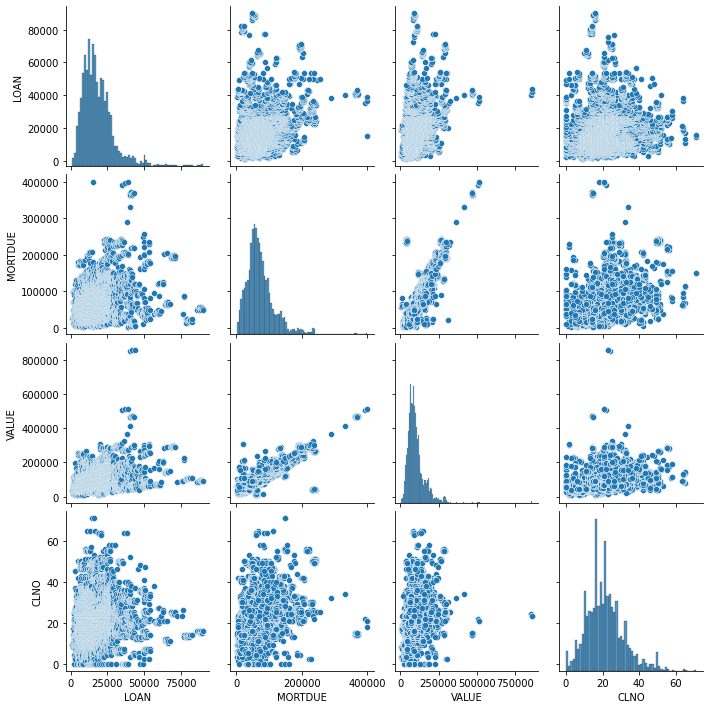

In [ ]:
sns.pairplot(df[pear_columns],kind="scatter")

We can use the plot to determine multicolinearity. Loan has a directly linear proportionality between the other datasets. Mortdue has a linear relatinoship with Value. Therefore either mortdue or value can be removed for the final multivariable regression.

In [ ]:
# Count the column with more data points to determine which variable to use: Mortdue or Value
print(np.count_nonzero(~np.isnan(df.MORTDUE)))
print(np.count_nonzero(~np.isnan(df.VALUE))) # More Value datapoints so this is used instead
# pear_columns.remove("MORTDUE")
# pear_columns.remove("LOAN")


5442
5848


In [ ]:
clean_df = df.fillna(0)[pear_columns].to_numpy()
clean_pear = pear[pear_columns].to_numpy()
pred = np.dot(clean_df,clean_pear.T)
df["Predicted_BAD"] = pred


(5960.0, 0.49025612364900045, 5958, array([[0.80050336, 0.19949664],
       [0.80050336, 0.19949664],
       [0.80050336, 0.19949664],
       ...,
       [0.80050336, 0.19949664],
       [0.80050336, 0.19949664],
       [0.80050336, 0.19949664]]))


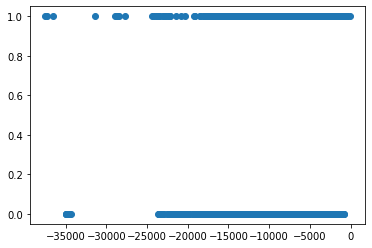

In [ ]:
pd.crosstab(df.Predicted_BAD,df.BAD,)
print(chi2_contingency(pd.crosstab(df.Predicted_BAD,df.BAD,)
))
plt.scatter(df.Predicted_BAD,df.BAD) ## Two groups, the higher the predicted BAD the higher the chance of defaulting
plt.show()

In [ ]:
mean = df.Predicted_BAD[df.BAD == 1].mean()
std = df.Predicted_BAD[df.BAD == 1].std()
HighRiskBound = mean + std
LowRiskBound = mean - std


In [ ]:
highRiskMask = df.Predicted_BAD >= HighRiskBound
lowRiskMask = df.Predicted_BAD <= LowRiskBound
mediumRiskMask= ~(lowRiskMask | highRiskMask)
df["RiskLevel"]=np.zeros(len(df["BAD"]))
df["RiskLevel"] = df.RiskLevel.mask(highRiskMask,"High Risk") 
df["RiskLevel"] = df.RiskLevel.mask(lowRiskMask,"Low Risk") 
df["RiskLevel"] = df.RiskLevel.mask(mediumRiskMask,"Medium Risk") 
# mask = df["RiskLevel"] == True
# df["RiskLevel"]=df["RiskLevel"].where(~mask,other="High Risk")